In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels as sm
import warnings
import scipy.integrate as integrate
from scipy.stats import truncnorm

import OptimalSequence

In [41]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.style.use('ggplot')

bins=20

## 1. Read the workload

In [42]:
# Load data from statsmodels datasets
#all_data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
up_bound = 6
low_bound = -4
mu = 8
sigma = 2

all_data = pd.Series(truncnorm.rvs(low_bound, up_bound, loc=mu, scale=sigma, size=1000))

In [43]:
test_cnt = int(len(all_data)/10)
testing = all_data[test_cnt:]
data =  all_data[:test_cnt]
data = data.append(pd.Series(max(all_data)))

In [44]:
print(r"        min max len")
print("testing", min(testing), max(testing), len(testing))
print("training", min(data), max(data), len(data))
print("all data", min(all_data), max(all_data), len(all_data))
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

        min max len
testing 2.260958082759762 14.589850685176451 900
training 2.2089671960011277 14.589850685176451 101
all data 2.2089671960011277 14.589850685176451 1000


## 2. For a given fit compute the PDF and CDF

In [45]:
def get_pdf(data, params, bins):
    f = np.poly1d(params)
    # compute the integral from xp[0] to xp[-1]
    area = integrate.quad(f, data[0], data[-1], epsrel=1.49e-05)
    if np.isclose(area[0], 1, rtol=1e-03):
        return f
    params = [i/area[0] for i in params]
    return np.poly1d(params)

In [46]:
def get_cdf(pdf, start, x):
    return integrate.quad(pdf, start, x, epsrel=1.49e-05)[0]

## 3. For a given fit compute the cost of the optimal sequence

In [47]:
def compute_cost(cdf, walltimes):
    handler = OptimalSequence.TOptimalSequence(min(walltimes), max(walltimes), cdf, )
    sequence = handler.compute_request_sequence()
    print(sequence)
    cost = 0
    for instance in walltimes:
        # get the sum of all the values in the sequences <= current walltime
        cost += sum([i for i in sequence if i < instance])
        # add the first reservation that is >= current walltime
        idx = 0
        if len(sequence) > 1:
            idx_list = [i for i in range(1,len(sequence)) if
                        sequence[i-1] < instance and sequence[i] >= instance]
            if len(idx_list) > 0:
                idx = idx_list[0]
        cost += sequence[idx]
    cost = cost / len(walltimes)
    return cost

In [48]:
min_error = 1
selected_order = 1
df = pd.DataFrame(columns=["Polynomial_order", "Cost", "Error"])
for order in range(1,30):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            z = np.polyfit(x, y, order)
        except:
            break
        err = np.sum((np.polyval(z, x) - y)**2)

        # save the best fitted polynomial
        if err < min_error:
            min_error = err
            selected_order = order

        # get the pdf and cdf functions
        try:
            pdf = get_pdf(x,z,bins)
            cdf = lambda val: get_cdf(pdf, x[0], val)
            print("Order", order, "Sequence")
            cost = compute_cost(cdf, testing)
        except:
            continue
        df.loc[len(df)] = [order, cost, err]

Order 1 Sequence
[11.754205386620612, 14.589850685176451]
Order 2 Sequence
[11.630916460596445, 12.124072164693112, 12.24736109071728, 12.370650016741447, 12.493938942765613, 12.617227868789781, 12.740516794813947, 12.863805720838114, 12.987094646862282, 13.110383572886448, 13.233672498910614, 13.356961424934783, 13.480250350958949, 13.603539276983115, 13.726828203007283, 13.85011712903145, 13.973406055055616, 14.096694981079784, 14.21998390710395, 14.343272833128117, 14.466561759152283, 14.589850685176451]
Order 3 Sequence
[11.01447183047561, 12.617227868789781, 12.740516794813947, 12.863805720838114, 12.987094646862282, 13.110383572886448, 13.233672498910614, 13.356961424934783, 13.480250350958949, 13.603539276983115, 13.726828203007283, 13.85011712903145, 13.973406055055616, 14.096694981079784, 14.21998390710395, 14.343272833128117, 14.466561759152283, 14.589850685176451]
Order 4 Sequence
[10.767893978427278, 12.124072164693112, 14.589850685176451]
Order 5 Sequence
[10.6446050524031

## 4. Get the cost using the sequence computed from the discreet data

In [49]:
def discreet_cdf(x, histogram, histogram_counts):
    # find the position in the histogram closest to x
    cum_histogram = np.cumsum(histogram_counts)
    min_dist = np.abs(x - histogram[0])
    count = cum_histogram[0]
    for bins in range(len(histogram)):
        dist = np.abs(x - histogram[bins])
        if dist < min_dist:
            min_dist = dist
            count = cum_histogram[bins]
    return count

In [50]:
yall = [i/sum(y) for i in y]
cdf_just_training = lambda val: discreet_cdf(val, x, yall)
cost_discreet = compute_cost(cdf_just_training, testing)
cost_discreet

[9.658293644209774, 12.124072164693112, 13.973406055055616, 14.096694981079784, 14.21998390710395, 14.343272833128117, 14.466561759152283, 14.589850685176451]


12.030317009851288

In [51]:
yall, xall = np.histogram(all_data, bins=bins, density=True)
xall = (xall + np.roll(xall, -1))[:-1] / 2.0
cdf_all_data = lambda val: discreet_cdf(val, xall, yall)
cost_discreet_all = compute_cost(cdf_all_data, testing)
cost_discreet_all

[9.658293644209774, 12.124072164693112, 13.973406055055616, 14.096694981079784, 14.21998390710395, 14.343272833128117, 14.466561759152283, 14.589850685176451]


12.030317009851288

## 3 Plot the cost of the sequence generated by polynomial fits of different orders

In [52]:
df

,Polynomial_order,Cost,Error
0,1.0,12.127057,0.112723
1,2.0,13.151650,0.044299
2,3.0,12.332132,0.037453
3,4.0,11.757226,0.018497
4,5.0,11.746949,0.013941
5,6.0,11.744537,0.013001
6,7.0,11.678692,0.010540
7,8.0,11.704715,0.010509
8,9.0,11.704715,0.010509
9,10.0,11.746949,0.009745


Text(0, 0.5, 'Cost')

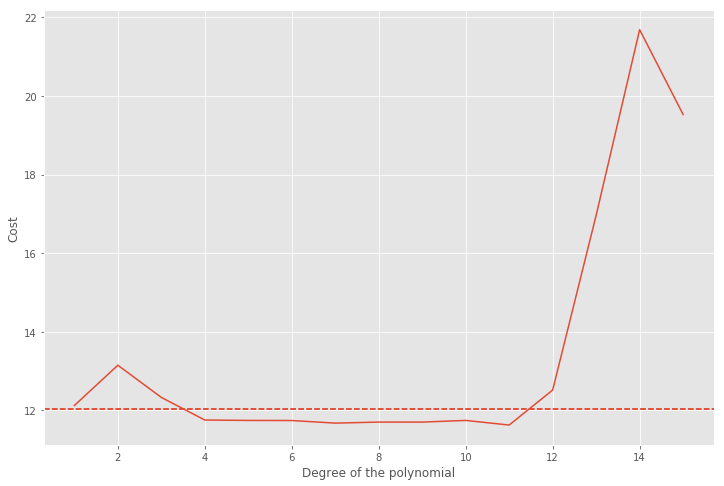

In [53]:
# plot the cost for different polynomial orders
plt.figure(figsize=(12,8))
ax = sns.lineplot(x="Polynomial_order", y="Cost", data=df)
ax.axhline(cost_discreet, ls='--')
ax.axhline(cost_discreet_all, ls='--')
ax.set_xlabel('Degree of the polynomial')
ax.set_ylabel('Cost')

### 3.2 Plot PDF and CDF for the best fit

In [54]:
z = np.polyfit(x, yall, selected_order)
pdf = get_pdf(x,z,bins)
print(df.loc[df['Error'].idxmin()], selected_order)
print(integrate.quad(pdf, x[0], x[-1], epsrel=1.49e-05))

Polynomial_order    15.000000
Cost                19.530264
Error                0.008588
Name: 14, dtype: float64 16
(1.0000006798624583, 7.253694122126082e-07)


In [55]:
cdf = lambda val: get_cdf(pdf, x[0], val)

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

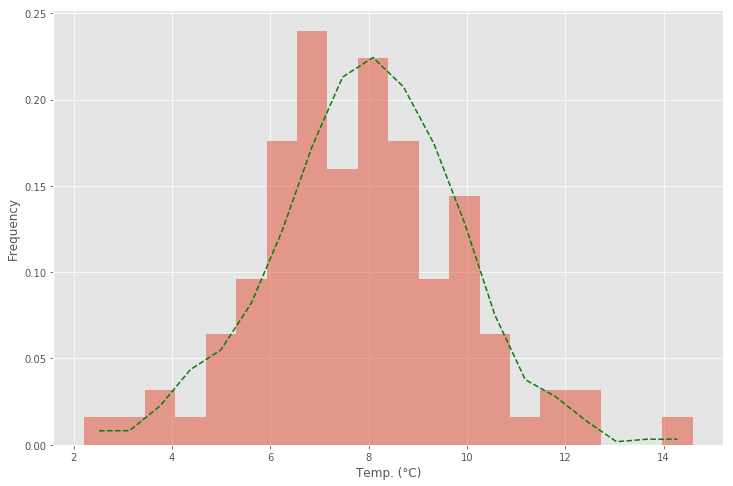

In [56]:
plt.figure(figsize=(12,8))
xp = np.linspace(x[0], x[-1], bins)
ax = data.plot(kind='hist', bins=bins, normed=True, alpha=0.5)
plt.plot(xp, pdf(xp), 'g--')
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

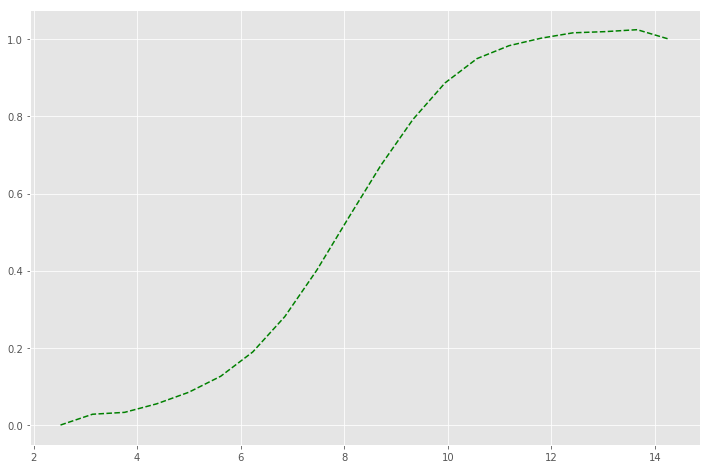

In [57]:
plt.figure(figsize=(12,8))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cdf_plot = [cdf(i) for i in xp]
plt.plot(xp, cdf_plot, 'g--')

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

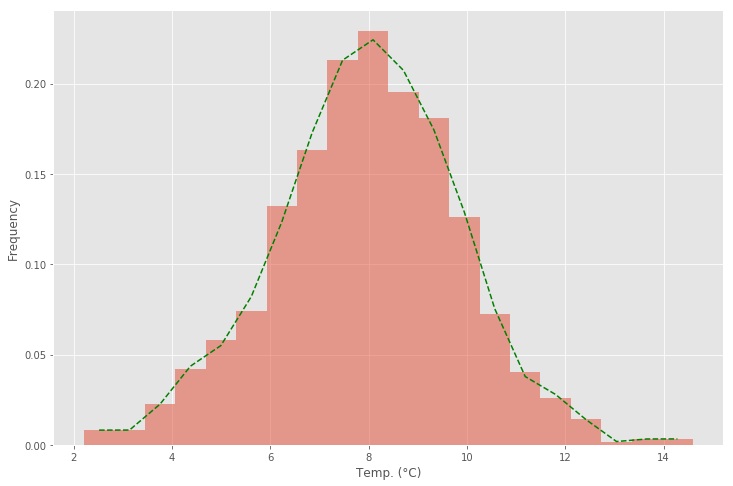

In [58]:
y, x = np.histogram(all_data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
plt.figure(figsize=(12,8))
xp = np.linspace(x[0], x[-1], bins)
ax = all_data.plot(kind='hist', bins=bins, normed=True, alpha=0.5)
plt.plot(xp, pdf(xp), 'g--')
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')